# Profiling, application à la convolution

Une [convolution](https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)) est une opération très fréquente en deep learning lorsqu'il s'agit d'interpréter des images. Elle est aussi coûteuse et c'est pour ça que beaucoup essayent d'accélérer son calcul à défaut de s'en passer.

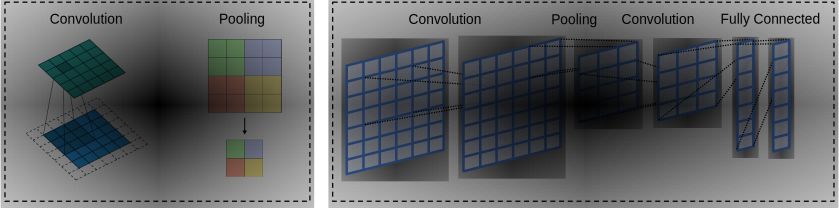

In [1]:
from IPython.display import SVG
SVG("https://upload.wikimedia.org/wikipedia/commons/9/9f/ConvolutionAndPooling.svg")

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Implémentation naïve

On implémente l'algorithme dans sa version naïve et on compare les résultats à la version implémentée dans [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).

In [3]:
import numpy

img = numpy.arange(49).reshape((7, 7)).astype(numpy.float32)
img

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 7.,  8.,  9., 10., 11., 12., 13.],
       [14., 15., 16., 17., 18., 19., 20.],
       [21., 22., 23., 24., 25., 26., 27.],
       [28., 29., 30., 31., 32., 33., 34.],
       [35., 36., 37., 38., 39., 40., 41.],
       [42., 43., 44., 45., 46., 47., 48.]], dtype=float32)

In [4]:
kernel = numpy.ones((3, 3)).astype(numpy.float32) / 9
kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

In [5]:
from scipy.signal import convolve2d
convolve2d(img, kernel, mode="valid")

array([[ 8.      ,  9.      , 10.      , 10.999999, 12.      ],
       [15.      , 16.000002, 17.      , 18.      , 19.      ],
       [22.      , 23.      , 24.000002, 25.      , 26.      ],
       [29.      , 30.000002, 31.      , 32.000004, 33.      ],
       [36.      , 37.      , 38.      , 39.000004, 40.000004]],
      dtype=float32)

In [6]:
def convolve_naive(x, kernel):
    res = numpy.zeros(x.shape, dtype=x.dtype)
    for i in range(1, x.shape[0] - 1):
        for j in range(1, x.shape[1] - 1):
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    res[i, j] += x[i + k - 1, j + l - 1] * kernel[k, l]
    return res

convolve_naive(img, kernel)

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  7.9999995,  9.       , 10.       , 11.       ,
        12.000001 ,  0.       ],
       [ 0.       , 15.       , 16.       , 17.       , 18.       ,
        19.       ,  0.       ],
       [ 0.       , 22.000002 , 23.       , 24.       , 25.       ,
        26.       ,  0.       ],
       [ 0.       , 29.       , 30.       , 31.000002 , 32.       ,
        33.000004 ,  0.       ],
       [ 0.       , 36.       , 37.       , 38.000004 , 39.       ,
        40.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ]], dtype=float32)

### Q1: comparer les temps d'exécution

Avec la fonction [timeit.repeat](https://docs.python.org/3/library/timeit.html#timeit.repeat).
Essayer avec des matrices plus grandes.

### Q2: comparer avec une seconde implémentation

La fonction suivante fait exactement la même chose. Est-elle plus rapide ?

In [7]:
def convolve_naive2(x, kernel):
    res = numpy.zeros(x.shape, dtype=x.dtype)
    for i in range(1, x.shape[0] - 1):
        for j in range(1, x.shape[1] - 1):
            res[i, j] += (x[i-1:i+2, j-1:j+2] * kernel).sum()
    return res

convolve_naive2(img, kernel)

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  8.      ,  9.      , 10.      , 11.      , 12.      ,
         0.      ],
       [ 0.      , 15.      , 16.      , 17.      , 18.      , 19.      ,
         0.      ],
       [ 0.      , 22.000002, 23.      , 24.      , 24.999998, 26.      ,
         0.      ],
       [ 0.      , 29.      , 30.      , 31.000002, 32.      , 33.000004,
         0.      ],
       [ 0.      , 36.      , 37.      , 38.      , 39.      , 40.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ]], dtype=float32)

On s'assure de façon plus méthodique que les deux fonctions retournent le même résultat en écrivant un test unitaire.

In [8]:
from numpy.testing import assert_almost_equal

def test_unitaire():
    assert_almost_equal(convolve_naive(img, kernel),
                        convolve_naive2(img, kernel),
                        decimal=5)

test_unitaire()

## im2col

`im2col` est une transformation de l'image `img` de sorte que la convolution devienne un produit matriciel. Comme un produit matriciel est un algorithme très utilisé, il existe de nombreuses implémentation optimisée. L'idée est que, même si on perd du temps à transformer la matrice initiale, on en gagne par la suite. Maintenant, comment faire pour que :

`convolve2d(img, kernel) = im2col(img) @ kernel.flatten()`

ou quelque chose de pas loin.

In [10]:
def _get_indices(i, shape):
    res = numpy.empty((len(shape), ), dtype=numpy.int64)
    k = len(shape) - 1
    while k > 0:
        m = i % shape[k]
        res[k] = m
        i -= m
        i /= shape[k]
        k -= 1
    res[0] = i
    return res


def _is_out(ind, shape):
    for i, s in zip(ind, shape):
        if i < 0:
            return True
        if i >= s:
            return True
    return False


def im2col_naive(data, kernel_shape, fill_value=0):
    if not isinstance(kernel_shape, tuple):
        raise TypeError(
            f"Unexpected type {type(kernel_shape)!r} for kernel_shape.")
    if len(data.shape) != len(kernel_shape):
        raise ValueError(
            f"Shape mismatch {data.shape!r} and {kernel_shape!r}.")
    output_shape = data.shape + kernel_shape
    res = numpy.empty(output_shape, dtype=data.dtype)
    middle = numpy.array([-m / 2 for m in kernel_shape], dtype=numpy.int64)
    kernel_size = numpy.prod(kernel_shape)
    data_size = numpy.prod(data.shape)
    for i in range(data_size):
        for j in range(kernel_size):
            i_data = _get_indices(i, data.shape)
            i_kernel = _get_indices(j, kernel_shape)
            ind = i_data + i_kernel + middle
            t_data = tuple(i_data)
            t_kernel = tuple(i_kernel)
            i_out = t_data + t_kernel
            res[i_out] = fill_value if _is_out(
                ind, data.shape) else data[tuple(ind)]
    return res.reshape(data.shape[:2] + (-1, ))


def convolve_im2col_naive(data, kernel, fill_value=0):
    res = im2col_naive(img, kernel.shape, fill_value=fill_value)
    conv = res @ kernel.flatten()
    conv[0, :] = fill_value
    conv[:, 0] = fill_value
    conv[-1, :] = fill_value
    conv[:, -1] = fill_value
    return conv

convolve_im2col_naive(img, kernel)

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  8.      ,  9.000001, 10.      , 11.      , 12.      ,
         0.      ],
       [ 0.      , 15.      , 16.      , 17.      , 18.      , 19.      ,
         0.      ],
       [ 0.      , 22.000002, 23.000002, 24.      , 24.999998, 26.      ,
         0.      ],
       [ 0.      , 29.      , 30.      , 31.000002, 32.      , 33.000004,
         0.      ],
       [ 0.      , 36.      , 37.      , 38.      , 39.      , 39.999996,
         0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [11]:
def test_unitaire2():
    assert_almost_equal(convolve_naive(img, kernel),
                        convolve_im2col_naive(img, kernel),
                        decimal=5)

test_unitaire2()

### Q3: comparer à nouveau les temps d'éxecution

## Profiling

La fonction `convolve_im2col_naive` est en fait composées de quatre fonctions. On sait mesurer le temps global mais cela n'aide pas à savoir dans quelle direction partir pour l'accélérer. Le profiling et justement l'outil qu'il nous faut. Il mesure le temps d'exécution passé dans chaque fonction.

In [13]:
import os
import sys
import IPython

def clean(profiling):
    "Cette fonction nettoie quelques chemins trop longs."
    profiling = profiling.replace("\\", "/")
    profiling = profiling.replace(r"C:/Users/xavie/AppData/Local/Temp", "")
    profiling = profiling.replace(os.path.dirname(numpy.__file__).replace("\\", "/"), "")
    profiling = profiling.replace(os.path.dirname(IPython.__file__).replace("\\", "/"), "")
    profiling = profiling.replace(sys.exec_prefix.replace("\\", "/"), "")
    return profiling

def profile_code():
    for i in range(0, 100):
        convolve_im2col_naive(img, kernel)

import cProfile, pstats, io
from pstats import SortKey
from io import StringIO

pr = cProfile.Profile(builtins=False)
pr.enable()

profile_code()

pr.disable()

s = StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(clean(s.getvalue()))

         133626 function calls in 0.514 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.514    0.257 /core/interactiveshell.py:3342(run_code)
        1    0.000    0.000    0.514    0.514 /ipykernel_22284/1758842938.py:1(<module>)
        1    0.000    0.000    0.514    0.514 /ipykernel_22284/1758842938.py:14(profile_code)
      100    0.002    0.000    0.514    0.005 /ipykernel_22284/912409707.py:48(convolve_im2col_naive)
      100    0.288    0.003    0.511    0.005 /ipykernel_22284/912409707.py:23(im2col_naive)
    88200    0.143    0.000    0.143    0.000 /ipykernel_22284/912409707.py:1(_get_indices)
    44100    0.076    0.000    0.076    0.000 /ipykernel_22284/912409707.py:14(_is_out)
      200    0.000    0.000    0.004    0.000 <__array_function__ internals>:177(prod)
      200    0.000    0.000    0.003    0.000 /core/fromnumeric.py:2927(prod)
      200    0.003    0.000    0.003 

### Q4: que peut-on en déduire ?

### Profilage : événements ou échantillonnage

Le profileur de python enregistre les événements du programme, il note chaque temps auquel il rentre et sort de chaque fonction. Cela lui permet de construire un graphe d'appel des fonctions.

In [15]:
from pyquickhelper.pycode.profiling import profile2graph, profile

stat, text = profile(profile_code)
gr = profile2graph(stat)
text_prof = clean(gr[0].to_text(fct_width=50))

# pour un affichage plus facile à comprendre
from IPython.display import display, HTML
display(HTML('<pre style="white-space: pre !important;">' + text_prof.replace(
    "<", "&lt;").replace(">", "&gt;") + "</pre>"))

Les langages interprétés sont plus faciles à profiler car c'est l'interpréteur qui enregistre les appels. Dans le cas d'un langage compilé (plus bas niveau) comme le C, C++, cette technique ne fonctionne pas. Le programme est converti en langage machine et inclure des instructions pour enregistrer les appels ralentit considérablement le programme au point de fausser la mesure.

Les profileurs procèdent alors en interrompant le programme, ils enregistrent alors la ligne qui est en train d'être exécutée car le compilateur a inséré des marqueurs qui permettent d'associer ligne de code et langage machine. Ces profileurs sont souvent considérés comme des [profileurs statistiques](https://en.wikipedia.org/wiki/Profiling_(computer_programming)#Statistical_profilers).

La fonction la plus coûteuse est la fonction la plus souvent interrompue puisque la probabilité d'interrompre le programme alors qu'il l'exécute est la plus grande. C'est ce que fait un profileur comme [py-spy](https://github.com/benfred/py-spy). Ces profileurs sont appelés **sampling profiler**. Cette technique est plus ou moins rapide selon le taux d'échantillonnage : plus le programme est interrompu, plus il est lent. Il faut également compiler le programme exécutable en ajoutant des informations de débuggage. Si le processeur sait quelle instruction il exécute, les informations de débuggage permettent de savoir à quelle ligne de code cette instruction machine appartient.

## Une dernière implémentation

In [16]:
def im2col_recursive(data, kernel_shape, fill_value=0):
    """
    Recursive implementation, falls back to
    @see fn im2col_naive_implementation for dimension `<= fall_back_dim`.
    The function is equivalent to
    :func:`torch.nn.Unfold` (but with `padding=1` on all dimensions).
    :param image: image (float)
    :param kernel_shape: kernel shape
    :param fill_value: fill value
    :param fall_back_dim: below that threshold,
        switches to @see fn im2col_naive_implementation.
    :return: result
    """
    if len(data.shape) <= 2:
        return im2col_naive(data, kernel_shape, fill_value)
    
    perm = numpy.arange(len(data.shape) * 2).tolist()
    del perm[1:2]
    perm.insert(len(data.shape), 1)

    res = []
    N0 = data.shape[0]
    k0 = kernel_shape[0]
    mini_kernel = kernel_shape[1:]
    mini_shape = data.shape[1:] + mini_kernel
    for i in range(N0):
        for k in range(k0):
            ii = k - k0 // 2 + i
            if ii < 0 or ii >= N0:
                cc = numpy.full(mini_shape, dtype=data.dtype,
                                fill_value=fill_value)
            else:
                # many computation are already done, results should be cached.
                cc = im2col_recursive(data[ii], mini_kernel, fill_value)
            cc2 = cc[numpy.newaxis, ...]
            res.append(cc2)

    final = numpy.vstack(res)
    new_shape = (N0, k0) + cc.shape
    resh = final.reshape(new_shape)
    return numpy.transpose(resh, tuple(perm))


im2col_recursive(img, (3, 3))

def convolve_im2col_recursive(data, kernel, fill_value=0):
    res = im2col_recursive(img, kernel.shape, fill_value=fill_value)
    conv = res @ kernel.flatten()
    conv[0, :] = fill_value
    conv[:, 0] = fill_value
    conv[-1, :] = fill_value
    conv[:, -1] = fill_value
    return conv


def test_unitaire3():
    assert_almost_equal(convolve_naive(img, kernel),
                        convolve_im2col_recursive(img, kernel),
                        decimal=5)

test_unitaire3()

Elle donne le même résultat.

### Q5: Que pouvez-vous dire de cette dernière implémentation ?